# Convolutional Autoencoders
## ... for genomics

### Carl Nettelblad
#### Division of Scientific Computing, IT department, UU

# Disclosure

Much of this work is due to my PhD student Kristiina Ausmees.

Our preprint, currently under editing for resubmission, is available at https://www.biorxiv.org/content/10.1101/2020.09.30.320994v1.full

Much of what we discuss will be beyond what's available there.
 * Mayhbe some inspiration for more outside-the-box than out-of-the-box usage of neural networks.

# Problem Setting

* Like you have seen, it is relevant to do dimensionality reduction on genomes. Multiple purposes:
    * Compensating for genetic background, stratification
    * Visualization
        * For interpretation or QC
* Existing "traditional" methods tend to rely on:
    * Heavy filtering of variant data (MAF range, thinning of marker set to avoid LD bias) and/or
    * Explicit modelling (e.g. coalescent model)

# Why autoencoders?
* We want a low-dim embedding in the latent dimension.
* We want to act in a mainly unsupervised setting.

# Why convolutional?
* Like images, genomes are inherently spatial.
 * Especially so in sexually reproducing eukaryotes.
  * Recombination and cis regulation at different length scales.
  * Recombination also gives rise to population-level LD.
  * "Interesting" exceptions such as gene drives and non-fixed inversions act locally.
* Convolutional networks allow the detection of local spatial structures.
 * Aggregation such as maxpooling to successively reduce dimensionality.

# Why not sequential?
* Genomes _are_ sequences.
* Biology never processes the full genome as a sequence. DNA and RNA polymerases work along far shorter stretches.
 * Transcription can be initiated and terminated in a multitude of places. There are roughly 30,000 initiation sites for DNA polymerase.
* Neural networks *are* getting better at maintaining longterm context.
  * Just feeding a network every single nucleotide from chromosome 1 to 23, in two copies, would be futile to train.

# What's in an image?
* Pixel data is typically discrete.
 * But 0-255 for each channel R, G, B, is still "pretty continuous".
* Image data is generally translation invariant.
 * A dog is a dog even if it's shifted a single pixel.
 * The weight sharing of convolutional networks promotes translation-invariant generalization.
 * Rotation invariance is trickier...

# What's in a genome?
* Genome data is typically discrete.
 * Nucleotide A, C, G, T or Alt/Ref (00/01/11; 0/1/2 for diploid).
* Genome data is very sensitive to shifting location.
 * Less so if full sequence is encoded.
 * More so if we focus on only known variant locations with Alt/Ref encoding.
 * Alt allele in variant $x$ is completely different from Alt allele in variant $x+1$.

# Our task
In order to use convolutional networks that can work well for image data, we need to take the differences for genomes into account.

* Encode input and output in a suitable way to account for discrete data.
* Add some degree of spatial dependence, while avoiding fully connected networks.

# Loss function

* For images, it is easy to use mean-square error. Mean-square error are also common (and implicit) in e.g. PCA.

# Loss function

* For images, it is easy to use mean-square error. Mean-square error are also common (and implicit) in e.g. PCA.
* Another option is to scale the genotype in the range $[0,1]$.

# Loss function

* For images, it is easy to use mean-square error. Mean-square error are also common (and implicit) in e.g. PCA.
* Another option is to scale the genotype in the range $[0,1]$.
* In the lab, you used binary crossentropy.

# Binary crossentropy
$\sum_i y_i \cdot \log \hat y_i + (1-y_i) \cdot \log(1-\hat y_i)$

Symmetric for 0/1, $y_i$ are target values, $\hat y_i$ model outputs.

# Binary crossentropy
$\sum_i y_i \cdot \log \hat y_i + (1-y_i) \cdot \log(1-\hat y_i)$

Symmetric for 0/1, $y_i$ are target values, $\hat y_i$ model outputs.

* Very weak signal fore heterozygote $0.5$.
* If activation function of output layer is a sigmoid, $0.5$ is also pretty hard to predict.

# Binary crossentropy
$\sum_i y_i \cdot \log \hat y_i + (1-y_i) \cdot \log(1-\hat y_i)$

Symmetric for 0/1, $y_i$ are target values, $\hat y_i$ model outputs.

* Very weak signal fore heterozygote $0.5$.
* If activation function of output layer is a sigmoid, $0.5$ is also pretty hard to predict.
* *Three* classes, not two.

# Categorical crossentropy
$\sum_i \sum_j y_{ij} \log \hat y_ij$

Not a single scalar as output, but three values.

How do we create this output?


# Categorical crossentropy
$\sum_i \sum_j y_{ij} \log \hat y_ij$

Not a single scalar as output, but three values.

How do we create this output? Tried two main options:
* Softmax
* Let scalar output estimate allele frequency, compute genotype probabilities according to Hardy-Weinberg equilibrium

When would you expect either of these to work well?


# Spatial dependence
* A fully connected network can have a lot of spatial dependence, but it has an explosion in the number of parameters.
* Locally connected networks are similar to convolutions, but without weight sharing.
* We opt for just adding a single trainable parameter per marker/variant.
  * What's the meaning of this parameter?
  * The network knows.
* Slightly more extensive version in the form of a scaling and a bias per activation in specific layers.

# Avoiding overfitting
We might have a shortage of training data.
* Image-based applications can frequently start out by transfer learning from something trained on Imagenet.
* Training on some of the huge biobank resources might change that.

Main strategies:
* Variational autoencoder
* Augmentation




# Augmentation
Create more input data from your input data.

For images:
* Modify brightness/contrast
* Rescale
* Salt and pepper noise

For us:
* Randomly missing/modified genotypes
 * Only in train, let desired target be correct, full, data
* Create missing data from full samples matching the behavior of real low density samples

# Evaluation
How do we evaluate a dimensionality reduction?

Remember, we train our model to do genotype reconstruction, but we do not (solely) care about genotype reconstruction.

# Visual inspection

PCA 2D visualization


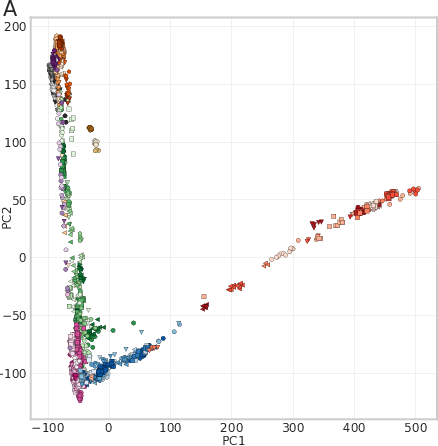

In [10]:
%config InlineBackend.figure_format='retina'
from wand.image import Image as WImage

fig = WImage(filename=('nbisgcae/pca.HumanOrigins2067_filtered.smartPCAstyle.flip_False.missing_val_-1.0_local.pdf'), resolution=125)
fig

# Visual inspection

Our 2D visualization

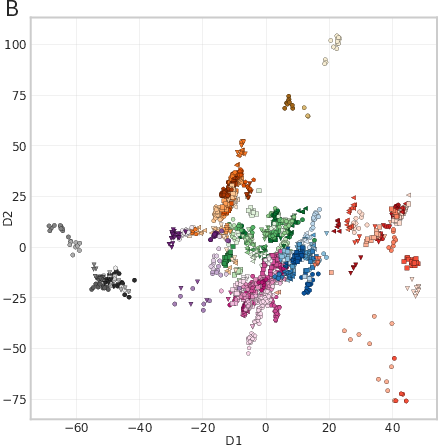

In [11]:
from wand.image import Image as WImage

fig = WImage(filename=('nbisgcae/dimred_e_180_by_superpop.pdf'), resolution=125)
fig

# Observations
Main hues, indicating contintens, separated more clearly. Individual colors and markers, indicating subpopulation labels, separated within colors. More space used. A "better" clustering.

Can we quantify this?

# kNN
The model did not see our population labels. It just considered unsupervised genome reconstruction. Similar genomes end up together in the embedding.

We can try to label each node using k-Nearest Neighbors (kNN). A good score there should indicate a good separation between subpopulations. Being able to separate subpopulations without training for it would indicate a well-resolved embedding.

# kNN

### 2-dim PCA: kNN for k = 3, 0.658

# kNN

### 2-dim PCA: kNN for k = 3, 0.658
### 2-dim GCAE: kNN for k = 3, 0.750


# kNN

### 2-dim PCA: kNN for k = 3, 0.658
### 2-dim GCAE: kNN for k = 3, 0.750
### 4-dim PCA: kNN for k = 3, 0.758


# The full network

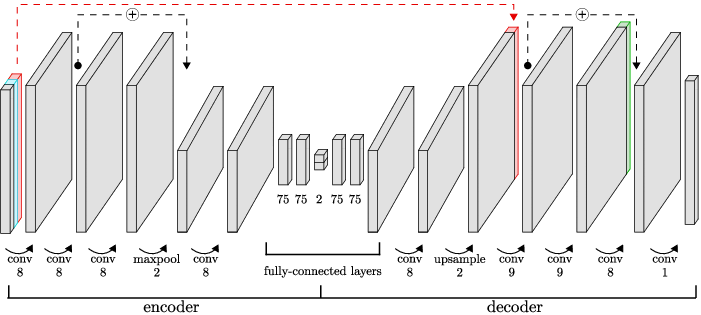

In [1]:
from wand.image import Image as WImage

fig = WImage(filename=('nbisgcae/ae_structure_less_detailed_2col.pdf'), resolution=100)
fig

# Population admixture
In population genetics studies on humans, admixture models as implemented in ADMIXTURE have been popular. Specific tool with specific model, sort of the opposite to doing PCA.

Assume $k$ founder populations, find the proportions $p_{ij}$ for the contribution of each of the $k$ populations to individual $i$, summing to $1$.

# ADMIXTURE example

TODO TODO

# Our example

TODO TODO


# What did we just do?
Change the latent layer. Rather than 2 components regularization and variational term, just change to $k$ dimensions, and normalize all dimensions to sum to 1.

# Adding phenotypes
What we have now is really four parts:
* An encoder network
* A latent layer operating in at least two models
* A decoder network
* Several ways to represent output with slightly different loss definitions

If we move from *population* to *quantitative* genetics, we want to know one thing:
* Predicting phenotypes from genotypes

# How?
* Convolutional regression network from encoder into phenotypes
  * Clearly works, but not all that exciting, prone to overfitting
* Co-training
  * Keep full autoencoder, create an extra networking working from latent representation to predict phenotypes
  * Might work, but hard to attribute phenotype to specific variants
* Inject phenotype
  * Turn the problem around

# Injecting phenotypes

* Train a decoder that uses both the genotype embedding *and* a (scaled) phenotype value.
* Embedding represents genetic background, phenotype the specific trait.


# Possible uses
* Prediction
  * Inference scan with different possible phenotype values
    * Select value with best decoding performance as point estimate
    * Get a range of possible values
* "What-if" scenarios
  * Start from individual X with phenotype value Y
  * What variants are most typically involved in the trait, *in this genetic background*

# Your mileage may vary
Master thesis student Karthik Nair tried this. Various hurdles, including a pandemic...

* As a validation experiment, we switched to a "phenotype" just consisting of a single SNP.

# Your mileage may vary
TODO 1

# Your mileage may vary
TODO 2

# Co-training
* Train a genotype decoder with a few dense layers on top of the embedding predicting phenotype, as well as the genotype reconstruction.
* Not providing variant associations beyond inspecting gradients.
* Tried in short master-level project course Clara Bernedal Nordström, Jennifer Johansson, and Johanna Öberg.
* Results this week.

# Fit the data
TODO 3

# Overfit the data
TODO 4

# Is it useful?
* By forcing the embedding to represent overall genome structure, we hope to get the model to learn real structure.
  * Avoid overfitting on fully random relationships.
* Within this short project, we didn't have enough time to validate whether generalization power increased.
* Possible usage mode: train embedding on a general (larger) set of reference genomes, then cotrain on genotype/phenotype reoncstruction for your study. Similar benefits to transfer learning in image tasks.

# Unnatural reconstructions
The categorical crossentropy loss will only look at individual genotypes in isolation.
* If all instances of the same marker are misinterpreted, this is not seen as a more severe error.
* If the haplotype structure is unnatural (not matching real LD), this is not seen as a more severe error.

What if we could get the model to identify anything "weird"?

# Adversarial networks
* We have an encoder $E$ and a decoder $D$. Both are trained on the reconstruction loss.

* In a typical generative adversarial network (GAN), there is a generator $G$ and a discriminator $D$
 * $G$ is fed random values in a low-dimensional room (such as our embedding).
 * $D$ is trained on the output from $G$ and from real examples.
   * Hand-waving: maximize output on values from $G$, minimize on values from real examples.
   * Opposite training goal for $D$.
* Basis for deep fakes.

# In our setting
* Joint training on reconstruction loss, and on fooling the discriminator.

* What network can we use as the basis for the discriminator?
  * Our encoder is already accepting genotype input data, so it can be reused.

# But...
* The output of our decoder is probabilities.
* The input of the encoder/discriminator is specific genotypes. And so are the true reference genomes.
* We can sample the output to give proper input to discriminator.
  * But this will not give a reasonable gradient.
  * Solution "Gumbel-Softmax", sampling with marginal non-zero probabilities for remaining genotypes with a "temperature" that can be adjusted.
* The discriminator is successful at discriminating, gibes a clear gradient signal to individual genotypes.
  * So far, we fail to actually get better results.


# Anything goes
* Lots of data has a genomic basis.
  * Transcriptome, epigenetics, proteome.
  * Additional input dimensions could be added beyond genotypes.
* Beyond adversarial, also looking a bit at attention approaches.
* We also had a master thesis by Alfred Andersson looking at normalizing genotype data from various SNP chips.
  * Another problem where specific methods have been used in the past.
  * Modified the autoencoder into more of a UNet structure.
  * UNet makes sense if we don't want to use the latent dimension directly in some way.

# Summary
Convolutional autoencoders can perform better than plain autoencoders.

A neural system can be tuned to do tasks that would rqeuire custom-made code in the classical world. The bulk of the work goes into finding a proper architecture, training, and augmentation strategy. Those can be shared. Co-training for multiple losses can also be beneficial.

# Questions